<a href="https://colab.research.google.com/github/rafaelcp/prelu_xor/blob/main/PReLU_Yet_Another_Single_Layer_Solution_to_the_XOR_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Main Experiment

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap

torch.manual_seed(42)

# Model definitions
class XOR_Tanh(nn.Module):
    def __init__(self):
        super(XOR_Tanh, self).__init__()
        self.hidden = nn.Linear(2, 2, bias=True)
        self.output = nn.Linear(2, 1, bias=False)
        self.tanh = nn.Tanh()
        with torch.no_grad():
            self.hidden.bias.data *= 0

    def forward(self, x):
        x = 1.7159 * self.tanh(2*self.hidden(x)/3) # Lecun's Tanh
        x = self.output(x)
        return x

class XOR_SingleLayer(nn.Module):
    def __init__(self):
        super(XOR_SingleLayer, self).__init__()
        self.linear = nn.Linear(2, 1, bias=False)
        self.prelu = nn.PReLU(init=0)

    def forward(self, x):
        x = self.linear(x)
        x = self.prelu(x)
        return x

class XOR_GCU(nn.Module):
    def __init__(self):
        super(XOR_GCU, self).__init__()
        self.linear = nn.Linear(2, 1, bias=True)
        with torch.no_grad():
            self.linear.bias.data *= 0

    def forward(self, x):
        x = self.linear(x)
        x = x * torch.cos(x)
        return x

# Data
X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

# Training function
def train_model(model, num_epochs=300):
    criterion = nn.MSELoss()
    lr = 0.1 if isinstance(model, (XOR_GCU, XOR_Tanh, XOR_SingleLayer)) else 0.01
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []
    successes = [0] * num_epochs

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        if type(model) == XOR_GCU:
          outputs = model(X)
        else:
          outputs = model(X*2-1)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        threshold = 0.5
        predicted = (outputs > threshold).float()
        successes[epoch] = torch.all(predicted == y).item()

    return model, losses, successes

# Testing function
def test_model(model):
    with torch.no_grad():
        if type(model) == XOR_GCU:
          outputs = model(X)
        else:
          outputs = model(X*2-1)
        threshold = 0.5
        predicted = (outputs > threshold).float()
        return torch.all(predicted == y).item()

# Experiment function
def run_experiment(model_class, num_experiments=100, num_epochs=1000):
    all_losses = []
    all_successes = []
    successes = 0
    runtimes = []
    all_models = []

    model = model_class()
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total number of learnable parameters for model {model_class.__name__}: {total_params}')

    for _ in range(num_experiments):
        start_time = time.time()
        model, losses, successes_list = train_model(model_class(), num_epochs)
        end_time = time.time()
        runtimes.append(end_time - start_time)

        all_losses.append(losses)
        all_successes.append(successes_list)
        successes += test_model(model)
        all_models.append(model)

    avg_losses = np.mean(all_losses, axis=0)
    std_losses = np.std(all_losses, axis=0)
    sem_losses = stats.sem(all_losses, axis=0)
    ci_losses = stats.t.interval(0.95, num_experiments-1, loc=avg_losses, scale=sem_losses)

    avg_successes = np.mean(all_successes, axis=0)
    std_successes = np.std(all_successes, axis=0)
    sem_successes = stats.sem(all_successes, axis=0)
    ci_successes = stats.t.interval(0.95, num_experiments-1, loc=avg_successes, scale=sem_successes)

    return avg_losses, std_losses, ci_losses, successes, avg_successes, std_successes, ci_successes, runtimes, all_models

# Define models to test
models = {
    'MLP (2 hidden Tanh)': XOR_Tanh,
    'Single Layer PReLU': XOR_SingleLayer,
    'Single Layer GCU': XOR_GCU,
}

# Run experiments
results = {}
num_experiments = 100
num_epochs = 300

for name, model_class in models.items():
    avg_losses, std_losses, ci_losses, successes, avg_successes, std_successes, ci_successes, runtimes, all_models = run_experiment(model_class, num_experiments, num_epochs)
    results[name] = {
        'avg_losses': avg_losses,
        'std_losses': std_losses,
        'ci_losses': ci_losses,
        'avg_successes': avg_successes,
        'std_successes': std_successes,
        'ci_successes': ci_successes,
        'successes': successes,
        'runtimes': runtimes,
        'all_models': all_models
    }
    print(f"{name} Success rate: {successes / num_experiments:.2%}")
    print(f"{name} Average runtime: {np.mean(runtimes):.2f} seconds")

Total number of learnable parameters for model XOR_Tanh: 8


/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2246: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2247: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


MLP (2 hidden Tanh) Success rate: 100.00%
MLP (2 hidden Tanh) Average runtime: 0.45 seconds
Total number of learnable parameters for model XOR_SingleLayer: 3
Single Layer PReLU Success rate: 100.00%
Single Layer PReLU Average runtime: 0.23 seconds
Total number of learnable parameters for model XOR_GCU: 3
Single Layer GCU Success rate: 100.00%
Single Layer GCU Average runtime: 0.22 seconds


# Print Results

In [3]:
# Print results
for name, data in results.items():
    print(f"\n{name}:")
    print(f"Success rate: {data['successes'] / num_experiments:.2%}")
    print(f"Number of successful experiments: {data['successes']} out of {num_experiments}")
    print(f"Average runtime: {np.mean(data['runtimes']):.2f} seconds")
    print(name, data['all_models'][0].state_dict())


MLP (2 hidden Tanh):
Success rate: 100.00%
Number of successful experiments: 100 out of 100
Average runtime: 0.45 seconds
MLP (2 hidden Tanh) OrderedDict([('hidden.weight', tensor([[2.5001, 2.6292],
        [2.0302, 2.1254]])), ('hidden.bias', tensor([ 1.0683, -0.6258])), ('output.weight', tensor([[ 0.5799, -0.5834]]))])

Single Layer PReLU:
Success rate: 100.00%
Number of successful experiments: 100 out of 100
Average runtime: 0.23 seconds
Single Layer PReLU OrderedDict([('linear.weight', tensor([[-0.5000,  0.5000]])), ('prelu.weight', tensor([-1.]))])

Single Layer GCU:
Success rate: 100.00%
Number of successful experiments: 100 out of 100
Average runtime: 0.22 seconds
Single Layer GCU OrderedDict([('linear.weight', tensor([[0.7727, 0.7727]])), ('linear.bias', tensor([0.0416]))])


# Plot Results

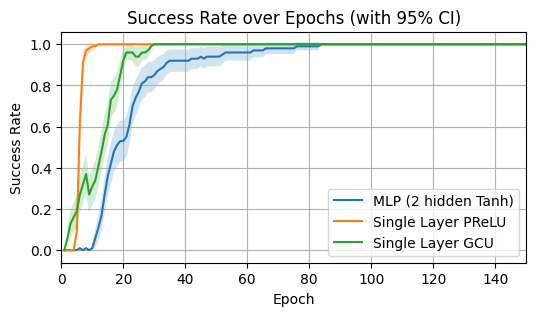

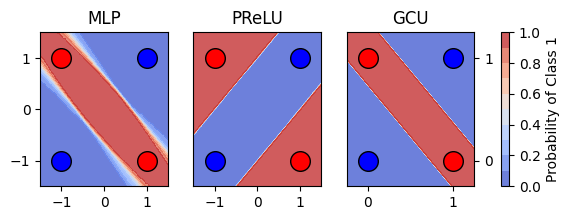

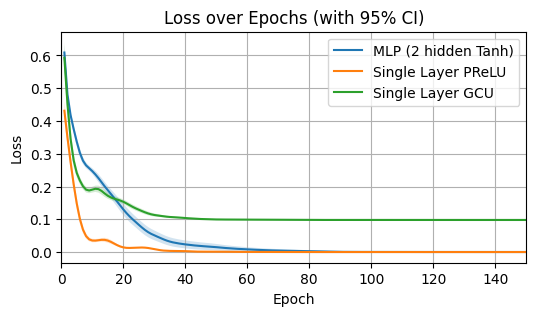

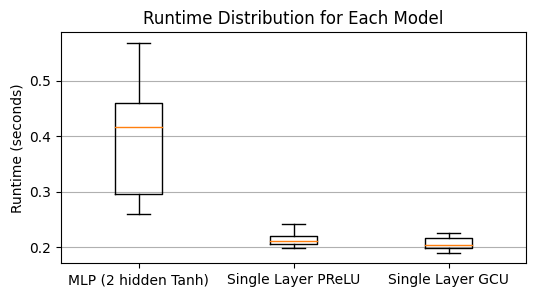

In [4]:
# Function to compute average decision boundary
def compute_average_decision_boundary(models, resolution=100):
    if type(models[0]) == XOR_GCU:
      x_min, x_max = -0.25, 1.25
      y_min, y_max = -0.25, 1.25
    else:
      x_min, x_max = -1.5, 1.5
      y_min, y_max = -1.5, 1.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))
    grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

    with torch.no_grad():
        Z = torch.zeros(grid.shape[0])
        for model in models:
            Z += (model(grid) > 0.5).float().squeeze()
        Z /= len(models)

    return xx, yy, Z.numpy().reshape(xx.shape)

# Function to plot average decision boundary
def plot_average_decision_boundary(models, ax):
    xx, yy, Z = compute_average_decision_boundary(models)

    cs = ax.contourf(xx, yy, Z, levels=np.linspace(0, 1, 11), cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot the four data points with colors matching their classes
    colors = ['blue', 'red', 'red', 'blue']  # Colors for [0,0], [0,1], [1,0], [1,1]
    if type(models[0]) == XOR_GCU:
      for i in range(4):
          ax.scatter(X[i, 0], X[i, 1], c=colors[i], edgecolors='black', s=200)
    else:
      for i in range(4):
          ax.scatter(X[i, 0]*2-1, X[i, 1]*2-1, c=colors[i], edgecolors='black', s=200)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return cs

# Plotting with confidence intervals
plt.figure(figsize=(6, 3))
plt.grid(True)
for name, data in results.items():
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, data['avg_successes'], label=name)
    plt.fill_between(epochs, data['ci_successes'][0], data['ci_successes'][1], alpha=0.2)

plt.xlabel('Epoch')
plt.ylabel('Success Rate')
plt.title('Success Rate over Epochs (with 95% CI)')
plt.xlim(0, 150)
plt.legend()
plt.savefig('success_rate_plot_with_ci.pdf', format='pdf', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

# Average Decision boundary plots
fig, axes = plt.subplots(1, 3, figsize=(7, 2))

for ax, (name, data) in zip(axes, results.items()):
    cs = plot_average_decision_boundary(data['all_models'], ax)
    if 'PReLU' in name:
      name = 'PReLU'
      ax.set_yticks([])
    if 'MLP' in name:
      name = 'MLP'
    if 'GCU' in name:
      name = 'GCU'
      ax.set_xticks([0,1])
      ax.set_yticks([0,1])
      ax.tick_params(
        axis='y',          # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,        # ticks along the left edge are off
        right=True,        # ticks along the right edge are off
        labelleft=False,   # labels along the left edge are off
        labelright=True)   # labels along the right edge are on
    ax.set_title(name)

# Add a colorbar
fig.colorbar(cs, ax=axes.ravel().tolist(), label='Probability of Class 1')

plt.savefig('average_decision_boundaries.pdf', format='pdf', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

# Loss plot with confidence intervals
plt.figure(figsize=(6, 3))
plt.grid(True)
for name, data in results.items():
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, data['avg_losses'], label=name)
    plt.fill_between(epochs, data['ci_losses'][0], data['ci_losses'][1], alpha=0.2)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs (with 95% CI)')
plt.xlim(0, 150)
plt.legend()
plt.savefig('loss_plot_with_ci.pdf', format='pdf', bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()

# Runtime boxplot
def plot_runtime_boxplot(results):
    plt.figure(figsize=(6, 3))
    plt.grid(True, axis='y')
    runtimes = [data['runtimes'] for data in results.values()]
    plt.boxplot(runtimes, labels=list(results.keys()), showfliers=False)
    plt.ylabel('Runtime (seconds)')
    plt.title('Runtime Distribution for Each Model')
    plt.savefig('runtime_boxplot.pdf', format='pdf', bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

# Call the runtime plotting function
plot_runtime_boxplot(results)

# Learning Rates Experiment

2-Layer Tanh - Learning rate: 0.001000, Accuracy: 0.00% ± 0.00%
2-Layer Tanh - Learning rate: 0.003162, Accuracy: 83.00% ± 3.78%
2-Layer Tanh - Learning rate: 0.010000, Accuracy: 99.00% ± 1.00%
2-Layer Tanh - Learning rate: 0.031623, Accuracy: 100.00% ± 0.00%
2-Layer Tanh - Learning rate: 0.100000, Accuracy: 100.00% ± 0.00%
2-Layer Tanh - Learning rate: 0.316228, Accuracy: 85.00% ± 3.59%
2-Layer Tanh - Learning rate: 1.000000, Accuracy: 34.00% ± 4.76%

2-Layer Tanh - Best learning rate: 0.100000
2-Layer Tanh - Best accuracy: 100.00% ± 0.00%

PReLU - Learning rate: 0.001000, Accuracy: 0.00% ± 0.00%
PReLU - Learning rate: 0.003162, Accuracy: 100.00% ± 0.00%
PReLU - Learning rate: 0.010000, Accuracy: 100.00% ± 0.00%
PReLU - Learning rate: 0.031623, Accuracy: 100.00% ± 0.00%
PReLU - Learning rate: 0.100000, Accuracy: 100.00% ± 0.00%
PReLU - Learning rate: 0.316228, Accuracy: 100.00% ± 0.00%
PReLU - Learning rate: 1.000000, Accuracy: 100.00% ± 0.00%

PReLU - Best learning rate: 1.000000
PRe

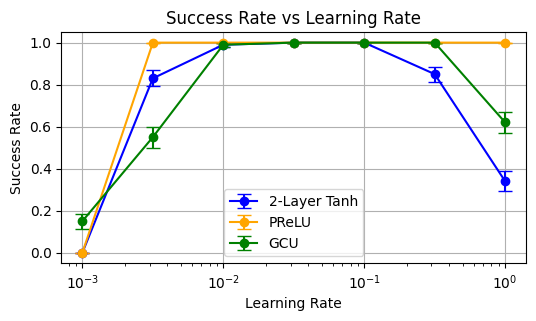

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

torch.manual_seed(42)

class XOR_SingleLayer(nn.Module):
    def __init__(self):
        super(XOR_SingleLayer, self).__init__()
        self.linear = nn.Linear(2, 1, bias=False)
        self.prelu = nn.PReLU(init=0)

    def forward(self, x):
        x = self.linear(x)
        x = self.prelu(x)
        return x

class XOR_GCU(nn.Module):
    def __init__(self):
        super(XOR_GCU, self).__init__()
        self.linear = nn.Linear(2, 1, bias=True)
        with torch.no_grad():
            self.linear.bias.data *= 0

    def forward(self, x):
        x = self.linear(x)
        x = x * torch.cos(x)
        return x

class XOR_Tanh(nn.Module):
    def __init__(self):
        super(XOR_Tanh, self).__init__()
        self.hidden = nn.Linear(2, 2, bias=True)
        self.output = nn.Linear(2, 1, bias=False)
        self.tanh = nn.Tanh()
        with torch.no_grad():
            self.hidden.bias.data *= 0

    def forward(self, x):
        x = 1.7159 * self.tanh(2*self.hidden(x)/3) # Lecun's Tanh
        x = self.output(x)
        return x

X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

def train_model(model, lr, num_epochs=300):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for _ in range(num_epochs):
        optimizer.zero_grad()
        if type(model) == XOR_GCU:
          outputs = model(X)
        else:
          outputs = model(X*2-1)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

def test_model(model):
    with torch.no_grad():
        if type(model) == XOR_GCU:
          outputs = model(X)
        else:
          outputs = model(X*2-1)
        threshold = 0.5
        predicted = (outputs > threshold).float()
        return torch.all(predicted == y).item()

def run_experiment(model_class, lr, num_trials=100, num_epochs=300):
    successes = []
    for _ in range(num_trials):
        model = model_class()
        train_model(model, lr, num_epochs)
        successes.append(test_model(model))
    return np.mean(successes), stats.sem(successes)

# Define learning rates to test
learning_rates = np.logspace(-3, 0, 7)  # 7 points from 10^-3 to 10^0

# Run experiments for all three models
models = [XOR_Tanh, XOR_SingleLayer, XOR_GCU]
model_names = ['2-Layer Tanh', 'PReLU', 'GCU']
colors = ['b', 'orange', 'g']

plt.figure(figsize=(6, 3))

for model_class, model_name, color in zip(models, model_names, colors):
    accuracies = []
    errors = []
    for lr in learning_rates:
        accuracy, error = run_experiment(model_class, lr)
        accuracies.append(accuracy)
        errors.append(error)
        print(f"{model_name} - Learning rate: {lr:.6f}, Accuracy: {accuracy:.2%} ± {error:.2%}")

    plt.errorbar(learning_rates, accuracies, yerr=errors, fmt='o-', capsize=5, label=model_name, color=color)

    # Find best learning rate
    best_lr_index = len(accuracies) - 1 - np.argmax(accuracies[::-1])
    best_lr = learning_rates[best_lr_index]
    best_accuracy = accuracies[best_lr_index]
    best_error = errors[best_lr_index]

    print(f"\n{model_name} - Best learning rate: {best_lr:.6f}")
    print(f"{model_name} - Best accuracy: {best_accuracy:.2%} ± {best_error:.2%}\n")

plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Success Rate')
plt.title('Success Rate vs Learning Rate')
plt.legend()
plt.grid(True)
plt.savefig('learning_rate_success.´pdf', format='pdf', bbox_inches='tight', pad_inches=0)
plt.show()